In [1]:
import os
import shutil
import random
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GaussianNoise, GlobalMaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import (
    cohen_kappa_score, matthews_corrcoef, roc_auc_score, log_loss,
    precision_score, recall_score, f1_score, confusion_matrix
)
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Images and Labels

In [2]:
# Paths
train_dir = '/content/drive/MyDrive/Split Dataset/train'
test_dir = '/content/drive/MyDrive/Split Dataset//test'

In [5]:
#  Loading images and label
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

Found 795 files belonging to 4 classes.
Found 201 files belonging to 4 classes.


In [6]:
# Class Names
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['Mild Dementia', 'Moderate Dementia', 'No Dementia', 'Severe Dementia ']


In [7]:
# Normalize the image data
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

## Normalizing Images

In [8]:
input_shape = (256, 256, 3)

# VGG16 For Image Classification

In [9]:
# Base Model
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(4, activation='softmax')
])

In [14]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [15]:
# Training the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 196s 8s/step - accuracy: 0.5939 - loss: 1.5113 - val_accuracy: 0.9104 - val_loss: 0.2881
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.9767 - loss: 0.1040 - val_accuracy: 0.9950 - val_loss: 0.0454
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 1.0000 - loss: 0.0254 - val_accuracy: 1.0000 - val_loss: 0.0223
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 1.0000 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 0.0189
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 0.0147
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.0114
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0107
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 

## Model Metrics

In [12]:
# Evaluation
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

predicted_labels = np.argmax(predictions, axis=1)

# F1 Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1}")

# Log Loss
logloss = log_loss(true_labels, predictions)
print(f"Log Loss: {logloss:.2f}")

# Cohen's Kappa Score
kappa = cohen_kappa_score(true_labels, predicted_labels)
print(f"Cohen's Kappa Score: {kappa:.2f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(true_labels, predicted_labels)
print(f"Matthews Correlation Coefficient: {mcc:.2f}")

# Specificity, Sensitivity, FPR, and FNR
cm = confusion_matrix(true_labels, predicted_labels)
specificities, sensitivities, fprs, fnrs = [], [], [], []
for i in range(len(class_names)):
    tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])  # True Negatives for class i
    fp = np.sum(cm[:, i]) - cm[i, i]  # False Positives for class i
    fn = np.sum(cm[i, :]) - cm[i, i]  # False Negatives for class i
    tp = cm[i, i]                     # True Positives for class i
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    specificities.append(specificity)
    sensitivities.append(sensitivity)
    fprs.append(fpr)
    fnrs.append(fnr)

print(f"Specificities: {specificities}")
print(f"Sensitivities (Recall): {sensitivities}")
print(f"False Positive Rates: {fprs}")
print(f"False Negative Rates: {fnrs}")

# G-Mean
g_mean = np.sqrt(np.mean(sensitivities) * np.mean(specificities))
print(f"G-Mean: {g_mean:.2f}")

# Fowlkes-Mallows Index (FMI)
fmi = np.sqrt(np.mean(precision_score(true_labels, predicted_labels, average=None)) * np.mean(recall_score(true_labels, predicted_labels, average=None)))
print(f"Fowlkes-Mallows Index: {fmi:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
Accuracy: 0.373134328358209
Classification Report:

                   precision    recall  f1-score   support

    Mild Dementia       0.13      0.30      0.18        27
Moderate Dementia       0.00      0.00      0.00        14
      No Dementia       0.49      0.68      0.57        98
 Severe Dementia        0.00      0.00      0.00        62

         accuracy                           0.37       201
        macro avg       0.15      0.24      0.19       201
     weighted avg       0.25      0.37      0.30       201

F1 Score: 0.3007167552070158
Log Loss: 1.48
Cohen's Kappa Score: -0.01
Matthews Correlation Coefficient: -0.01
Specificities: [0.6839080459770115, 1.0, 0.3106796116504854, 1.0]
Sensitivities (Recall): [0.2962962962962963, 0.0, 0.6836734693877551, 0.0]
False Positive Rates: [0.3160919540229885, 0.0, 0.6893203883495146, 0.0]
False Negative Rates: [0.7037037037037037, 1.0, 0.3163265306122449, 1.0]
G-Mean: 0.43
Fowlkes-Mallows Index: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

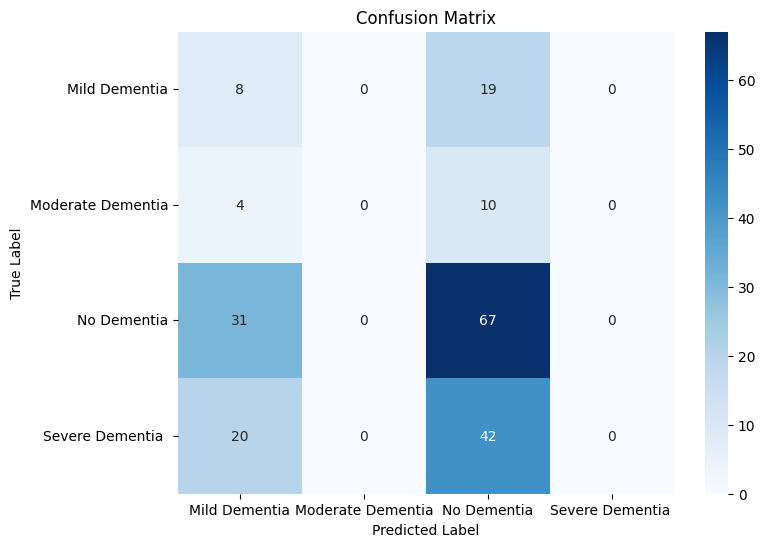

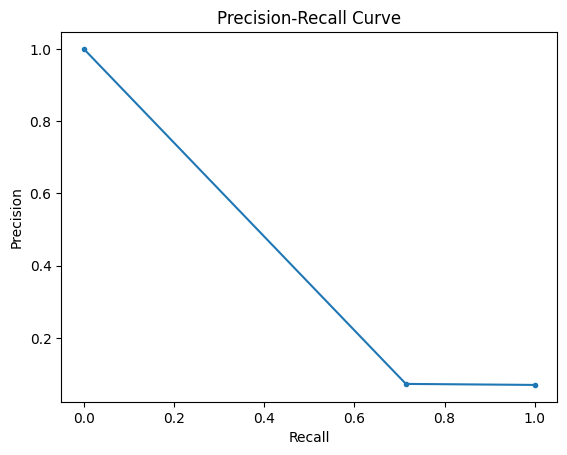

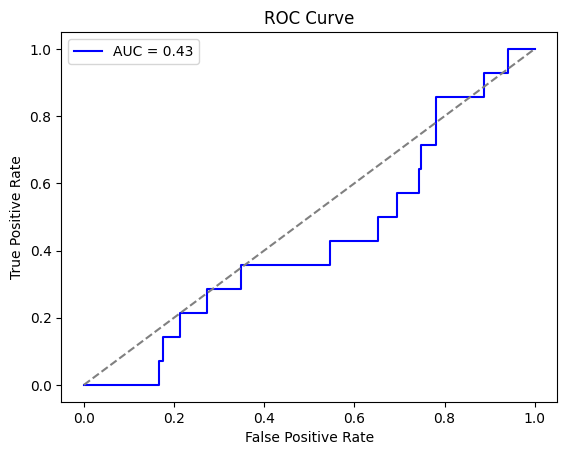

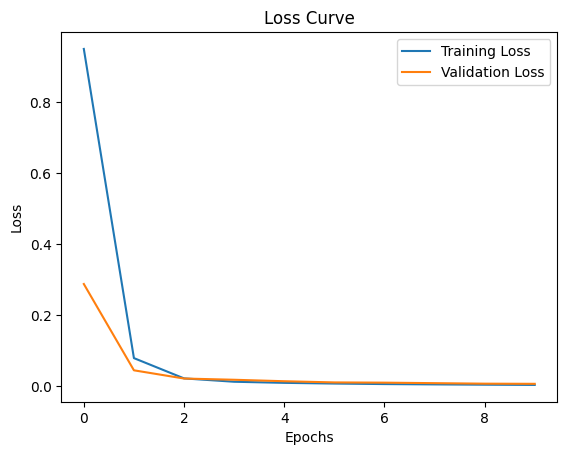

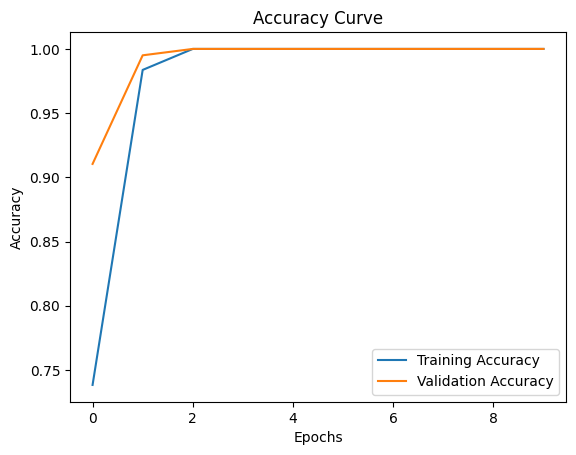

In [16]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, predicted_labels, pos_label=1)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Loss Curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#  Accuracy Curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()